In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
import matplotlib.pyplot as plt
import random

In [2]:
d = 2

shapes = {
    (0, 0): (2, 2, d),
    (0, 1): (2, 2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, d),
    (2, 2): (2, d)}
nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (2, 2), 1, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [3]:
local_state = np.array([0,1])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0,1])
white_state = np.array([1,0])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = 1,  pattern = "checkerboard")

In [4]:
#ttn.canonical_form("Site(2,2)" , ptn.SplitMode.FULL)
#ttn.canonical_form("Site(1,2)" , ptn.SplitMode.REDUCED)
#ttn.canonical_form("Site(2,2)" , ptn.SplitMode.REDUCED)

In [5]:
t = 0.1
u = 4
m = 1
Lx = 3
Ly = 3

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

Corr = ptn.Correlation_function("Site(0,0)", "Site(2,2)", d)
Corr = Corr.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(Corr, ttn)

spatial_corr_dist_1 = ptn.spatial_correlation_function(Lx, Ly, 1, d)
spatial_corr_dist_1 = spatial_corr_dist_1.pad_with_identities(ttn, symbolic= True)
spatial_corr_dist_1 = ptn.TTNO.from_hamiltonian(spatial_corr_dist_1, ttn)

spatial_corr_dist_2 = ptn.spatial_correlation_function(Lx, Ly, 2, d)
spatial_corr_dist_2 = spatial_corr_dist_2.pad_with_identities(ttn, symbolic= True)
spatial_corr_dist_2 = ptn.TTNO.from_hamiltonian(spatial_corr_dist_2, ttn)

node_id_list = list(ttn.nodes.keys())
N_local_list = []
for node_id in node_id_list:
    N_local = ptn.Number_op_local(node_id, d)
    N_local = N_local.pad_with_identities(ttn, symbolic= True)
    N_local = ptn.TTNO.from_hamiltonian(N_local, ttn)
    N_local_list.append(N_local)

N = ptn.Number_op_total(Lx, Ly, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)    

random_op = ptn.Random_op(ttn, Lx= Lx, Ly= Ly, dim = d, seed= 10)
random_op = random_op.pad_with_identities(ttn, symbolic= False)
Rand = ptn.TTNO.from_hamiltonian(random_op, ttn)

In [6]:
L = Lx * Ly

# state_vector
state_vector , state_order = ttn.completely_contract_tree(to_copy= True)
print("State vector shape: ", state_vector.shape)
print("State order: ", state_order)
state_vector = state_vector.reshape((d**L))

# BH hamiltonian matrix
BH_exact = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, d)
BH_exact = BH_exact.pad_with_identities(ttn , symbolic= True)
BH_exact = BH_exact.to_tensor(ttn)
print("ham_order", BH_exact.node_identifiers)
BH_exact = BH_exact.operator
print( "L_tn.shape" , BH_exact.shape) 
BH_exact = BH_exact.reshape((d**L , d**L))
BH_exact = BH_exact.T

# Correlation function matrix
Corr_exact = ptn.Correlation_function("Site(0,0)", "Site(2,2)", d)
Corr_exact = Corr_exact.pad_with_identities(ttn, symbolic= True)
Corr_exact = Corr_exact.to_tensor(ttn)
print("op_order" , Corr_exact.node_identifiers)
Corr_exact = Corr_exact.operator
print("op.shape" , Corr_exact.shape) 
Corr_exact= Corr_exact.reshape((d**L, d**L))
Corr_exact = Corr_exact.T

# Spatial correlation function matrix
spatial_corr_dist_2_exact = ptn.spatial_correlation_function(Lx, Ly, 2, d)
spatial_corr_dist_2_exact = spatial_corr_dist_2_exact.pad_with_identities(ttn, symbolic= True)
spatial_corr_dist_2_exact = spatial_corr_dist_2_exact.to_tensor(ttn)
print("op_order" , spatial_corr_dist_2_exact.node_identifiers)
spatial_corr_dist_2_exact = spatial_corr_dist_2_exact.operator
print("op.shape" , spatial_corr_dist_2_exact.shape)
spatial_corr_dist_2_exact = spatial_corr_dist_2_exact.reshape((d**L, d**L))
spatial_corr_dist_2_exact = spatial_corr_dist_2_exact.T

State vector shape:  (2, 2, 2, 2, 2, 2, 2, 2, 2)
State order:  ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
ham_order ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
L_tn.shape (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
op_order ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
op.shape (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
op_order ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
op.shape (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


In [7]:
exact = ptn.ExactTimeEvolution(initial_state = state_vector, 
                               hamiltonian = BH_exact, 
                               time_step_size = 0.001,
                               final_time= 0.1,
                               operators= spatial_corr_dist_2_exact)

lanczos_params =  {'N_min': 2,   
                   'N_max': 20,           
                   'P_tol': 1e-6,          
                   'reortho': True,}
expansion_params = {"ExpansionMode": ptn.ExpansionMode.Partial_T3N,
                    "num_vecs": 1,
                    "tau": 1e-2,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                    "expansion_steps": 100,
                    "tol": 1e-60,
                    "tol_step": 1e5,
                    "max_bond": 80,
                    "rel_tot_bond": np.inf,
                    "T3NMode" : ptn.T3NMode.SVD,
                    "T3N_contr_mode" : ptn.ContractionMode.UCONTR,
                    "T3N_dict":None}


config= ptn.TTNTimeEvolutionConfig(record_bond_dim = False,
                                   Lanczos_evolution= False,
                                   Lanczos_params = lanczos_params,
                                   Expansion_params = expansion_params)

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.001,
                                 final_time = 0.1,
                                 operators = [spatial_corr_dist_2],
                                 config = config)

AttributeError: module 'pytreenet' has no attribute 'ExpansionMode'

In [ ]:
b

NameError: name 'b' is not defined

In [ ]:
exact.run(evaluation_time=2)

100%|██████████| 101/101 [00:00<00:00, 425.16it/s]


In [ ]:
tdvp.RUN(evaluation_time=2)
times = tdvp.times()

100%|██████████| 101/101 [00:06<00:00, 14.87it/s]

tol : 1e-60
expanded_dim : 25 : 30 ---> 55


In [ ]:
tdvp.results.shape

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


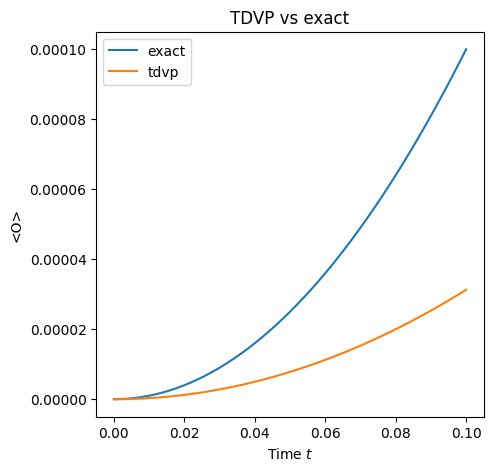

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

# First plot
axs1.plot(times , exact.operator_results()[0], label='exact')
axs1.plot(times , tdvp.operator_results()[0], label='tdvp')
#axs1.plot(times , tdvp_pad, label='tdvp_pad , 1.11s')
axs1.set_xlabel("Time $t$")
axs1.set_ylabel("<O>")
axs1.set_title("TDVP vs exact")

# Add a legend to distinguish between the two plots
axs1.legend()

plt.show()

In [ ]:
# Example usage:
# System initialization
Lx = 4
Ly = 4
n_bosons = 2
J = 2
U = 0.1
mu = 0
system = ptn.BoseHubbard2D(Lx, Ly, n_bosons, J, U, mu)

# Create initial state
initial_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
psi0 = system.uniform_product_state(initial_state)

black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")

# Evolve system
end_time = 1
dt = 0.01
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


In [ ]:
eval_time = 2
occupations, occ_times = system.occupation_results(eval_time, result)


time_steps = occupations.shape[0]
time = np.arange(time_steps)
occupations_flat = occupations.reshape(time_steps, -1)

# Plot all occupations in the same plot
plt.figure(figsize=(10, 6))
for i in range(occupations_flat.shape[1]):
    plt.plot(occ_times, occupations_flat[:, i], label=f'Site {i + 1}')

plt.xlabel('Time')
plt.ylabel('Occupation')
plt.title('Local Occupations of Sites in 2D Lattice Over Time')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# Select time indices for 6 evenly spaced time steps
time_indices = np.linspace(0, time_steps - 1, 6, dtype=int)

# Plot heatmaps for selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, time_index in zip(axes.flat, time_indices):
    # Plot heatmap of the lattice occupation at the selected time step
    im = ax.imshow(occupations[time_index], cmap='viridis', origin='lower')
    ax.set_title(f"Time step {time_index}")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")

# Add a color bar to indicate the occupation scale
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Occupation")

plt.suptitle("Evolution of Local Occupation Over Time (Heatmap)")


In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

mean_occupation = np.mean(occupations, axis=(1,2))
std_occupation = np.std(occupations, axis=(1,2))
ax1.plot(occ_times, mean_occupation, 'b-', label='Mean')
ax1.fill_between(occ_times, 
             mean_occupation - std_occupation,
             mean_occupation + std_occupation,
             alpha=0.3, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupation number')
ax1.set_title('Mean Occupation Evolution')
ax1.grid(True)
ax1.legend()

In [ ]:
eval_time = 2
correlations_hv, corr_times = system.spatial_correlation_function_results(
  eval_time, result, distance=2, mode="HV" , Normalize= False)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(corr_times, correlations_hv, 'r-', label='HV')
ax1.set_xlabel('Time')
ax1.set_ylabel('Spatial correlation')
ax1.set_title('Spatial Correlations')
ax1.grid(True)
ax1.legend()

In [ ]:
density_corr_hv, corr_times = system.density_density_correlation_results(
  eval_time, result, distance=2, mode="HV", Normalize= False)

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(corr_times, density_corr_hv, 'r-', label='HV')
ax1.set_xlabel('Time')
ax1.set_ylabel('Re[Density-density correlation]')
ax1.set_title('Density-Density Correlations (Real)')
ax1.grid(True)
ax1.legend()